In this project, we will work with the medical mnist datasource, specifically the pneumonia dataset from https://medmnist.com/ . The problem consists of classifying chest x-ray images as having pneumonia or not. Run the below lines of code to install the appropriate dataloaders and visualize the data

In [1]:
!pip install -qqq medmnist

In [2]:
from tqdm import tqdm
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
from numpy.random import RandomState
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import Subset
import re
from torchvision import datasets, transforms

In [3]:
def train(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy_with_logits(output, target.float())
        loss.backward()
        optimizer.step()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

def test(model, device, test_loader, name="\nVal"):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.binary_cross_entropy_with_logits(output, target.float(), size_average=False).item() # sum up batch loss
            pred = output >= 0.5 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

*** Challenge 2***

You may use the same testbed but without the constraints on external datasets or models trained on external datasets. See the full project description for the constraints on the external data or models. You may not, however, use any of the PneumoniaMnist training set. 

In [4]:
def resNet18():
    resNet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
    resNet18.fc = nn.Linear(in_features=512, out_features=1, bias=True)
    return resNet18

def resNet34():
    resNet34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
    resNet34.fc = nn.Linear(in_features=512, out_features=1, bias=True)
    return resNet34

def resNet50():
    resNet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
    resNet50.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
    return resNet50

def resNet101():
    resNet101 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
    resNet101.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
    return resNet101

def resNet152():
    resNet152 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
    resNet152.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
    return resNet152

In [5]:
resNets = [resNet18, resNet34, resNet50, resNet101, resNet152]

In [6]:
%%time
from random import randint

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(0)
np.random.seed(0)

# preprocessing
data_flag = 'pneumoniamnist'
download = True

info = INFO[data_flag]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([
      transforms.Resize(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[.5], std=[.5]),
      transforms.Lambda(lambda x: x.repeat(3, 1, 1) )
      ])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='train', transform=data_transform, download=download)

loss18_val = []
loss34_val = []
loss50_val = []
loss101_val = []
loss152_val = []
accs_val = []
seed = randint(0,50)

for resNet in resNets:
    if resNet is resNet18:
        print("ResNet18: ")
    elif resNet is resNet34:
        print("ResNet34: ")
    elif resNet is resNet50:
        print("ResNet50: ")
    elif resNet is resNet101:
        print("ResNet101: ")
    elif resNet is resNet152:
        print("ResNet152: ")
    params_to_update = []
    prng = RandomState(seed)
    random_permute = prng.permutation(np.arange(0, 1000))
    train_top = 10//n_classes
    val_top = 1000//n_classes
    indx_train = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[0:train_top]] for label in range(0, n_classes)])
    indx_val = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[train_top:train_top + val_top]] for label in range(0, n_classes)])

    train_data = Subset(train_dataset, indx_train)
    val_data = Subset(val_dataset, indx_val)

    print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

    train_loader = torch.utils.data.DataLoader(train_data,
                                                batch_size=32, 
                                                shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_data,
                                                batch_size=128, 
                                                shuffle=False)
    model = resNet()
    

    for param in model.layer4.parameters():
        params_to_update.append(param)

    for param in model.fc.parameters():
        params_to_update.append(param)

    model.to(device) 
    optimizer = torch.optim.Adam(params_to_update,lr=1e-3)

    for epoch in range(10):
        l = train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
        if resNet is resNet18:
            loss18_val.append(l)
        elif resNet is resNet34:
            loss34_val.append(l)
        elif resNet is resNet50:
            loss50_val.append(l)
        elif resNet is resNet101:
            loss101_val.append(l)
        elif resNet is resNet152:
            loss152_val.append(l)
    accs_val.append(test(model, device, val_loader))

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
ResNet18: 
Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.747552
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000547


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Val set: Average loss: 2.0016, Accuracy: 500/1000 (50.00%)

ResNet34: 
Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Train Epoch: 0 [0/10 (0%)]	Loss: 0.662212
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000581

Val set: Average loss: 1.0166, Accuracy: 641/1000 (64.10%)

ResNet50: 
Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Train Epoch: 0 [0/10 (0%)]	Loss: 0.722164
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000232

Val set: Average loss: 1.2877, Accuracy: 657/1000 (65.70%)

ResNet101: 
Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Train Epoch: 0 [0/10 (0%)]	Loss: 0.723848
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000584

Val set: Average loss: 4.3485, Accuracy: 501/1000 (50.10%)

ResNet152: 
Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Train Epoch: 0 [0/10 (0%)]	Loss: 0.701884
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000041

Val set: Average loss: 1.5620, Accuracy: 711/1000 (71.10%)

CPU times: user 27min 44s, sys: 1min 9s, total: 28min 53s
Wall time: 29min 7s


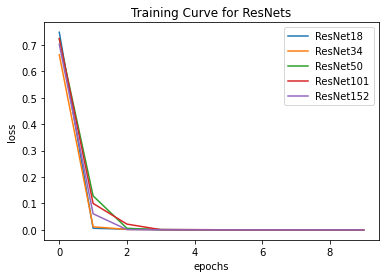

In [7]:
import matplotlib.pyplot as plt

plt.plot(loss18_val, label="ResNet18")
plt.plot(loss34_val, label="ResNet34")
plt.plot(loss50_val, label="ResNet50")
plt.plot(loss101_val, label="ResNet101")
plt.plot(loss152_val, label="ResNet152")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Training Curve for ResNets');
plt.savefig('pretrainedresnets_training.png')

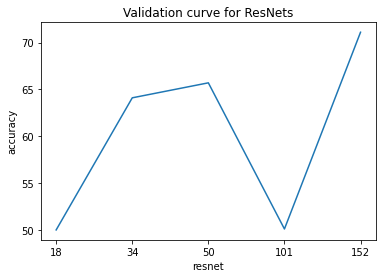

In [8]:
import matplotlib.pyplot as plt

x = ['18', '34', '50', '101', '152']
plt.plot(x , accs_val)
plt.xlabel('resnet')
plt.ylabel('accuracy')
plt.title('Validation curve for ResNets');
plt.savefig('pretrainedresnets_validation.png')